In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

def load_data():
    df = pd.read_csv('/data/fermilab-accelerator-ai/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz')
    #/data/fermilab-accelerator-ai/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5.cvs')
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna(axis=0)
    #df=df.round(decimals=5)
    return df

df = load_data()
print(df.head())

                      time   B:ACMNPG    B:GMPS4V  B:IMINER   B:LINFRQ  \
0  2020-03-10 05:00:00.048  10.000006  123.134498 -0.270313  26.063342   
1  2020-03-10 05:00:00.114  10.000006  119.234494 -0.305312  26.008777   
2  2020-03-10 05:00:00.180  10.000006  142.959518 -0.260313  26.081531   
3  2020-03-10 05:00:00.246  10.000006  133.534509 -0.185312  26.208850   
4  2020-03-10 05:00:00.312  10.000006   94.534470 -0.095312  26.208850   

      B:VIMAX     B:VIMIN  B:VINHBT  B:VIPHAS   B_ACMNPG     B_VIMIN  \
0  966.083496  103.379570       1.0  1.811700  10.000006  103.393158   
1  966.073730  103.421227       1.0  1.812469  10.000006  103.393158   
2  966.037720  103.425453       1.0  1.810874  10.000006  103.393158   
3  966.054077  103.420357       1.0  1.812430  10.000006  103.393158   
4  966.031189  103.412270       1.0  1.813190  10.000006  103.393158   

   B_VINHBT       I:IB     I:MDAT40       I:MXIB  
0       1.0  7055.9375  6977.386446  6974.145508  
1       1.0  7017.18

<class 'pandas.core.frame.DataFrame'>


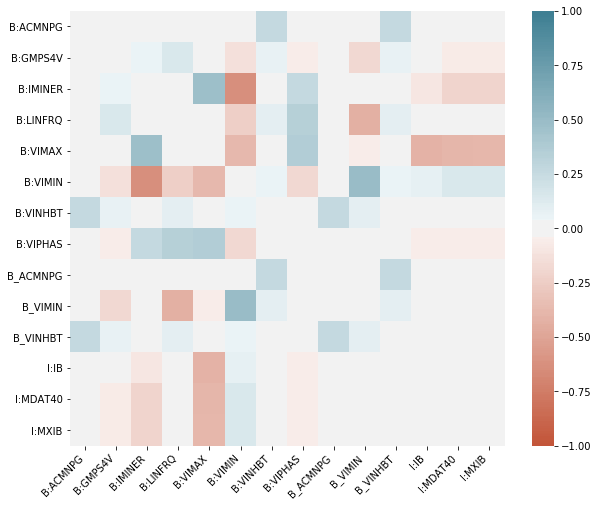

In [3]:
#####################################
## PLOT BASIC CORRELATION FUNCTION ##
#####################################
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
corr[corr > 0.9] = 0
print(type(corr))
c = corr.abs()
s = c.unstack()
so = s.sort_values(ascending = False)
#print(so.columns)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

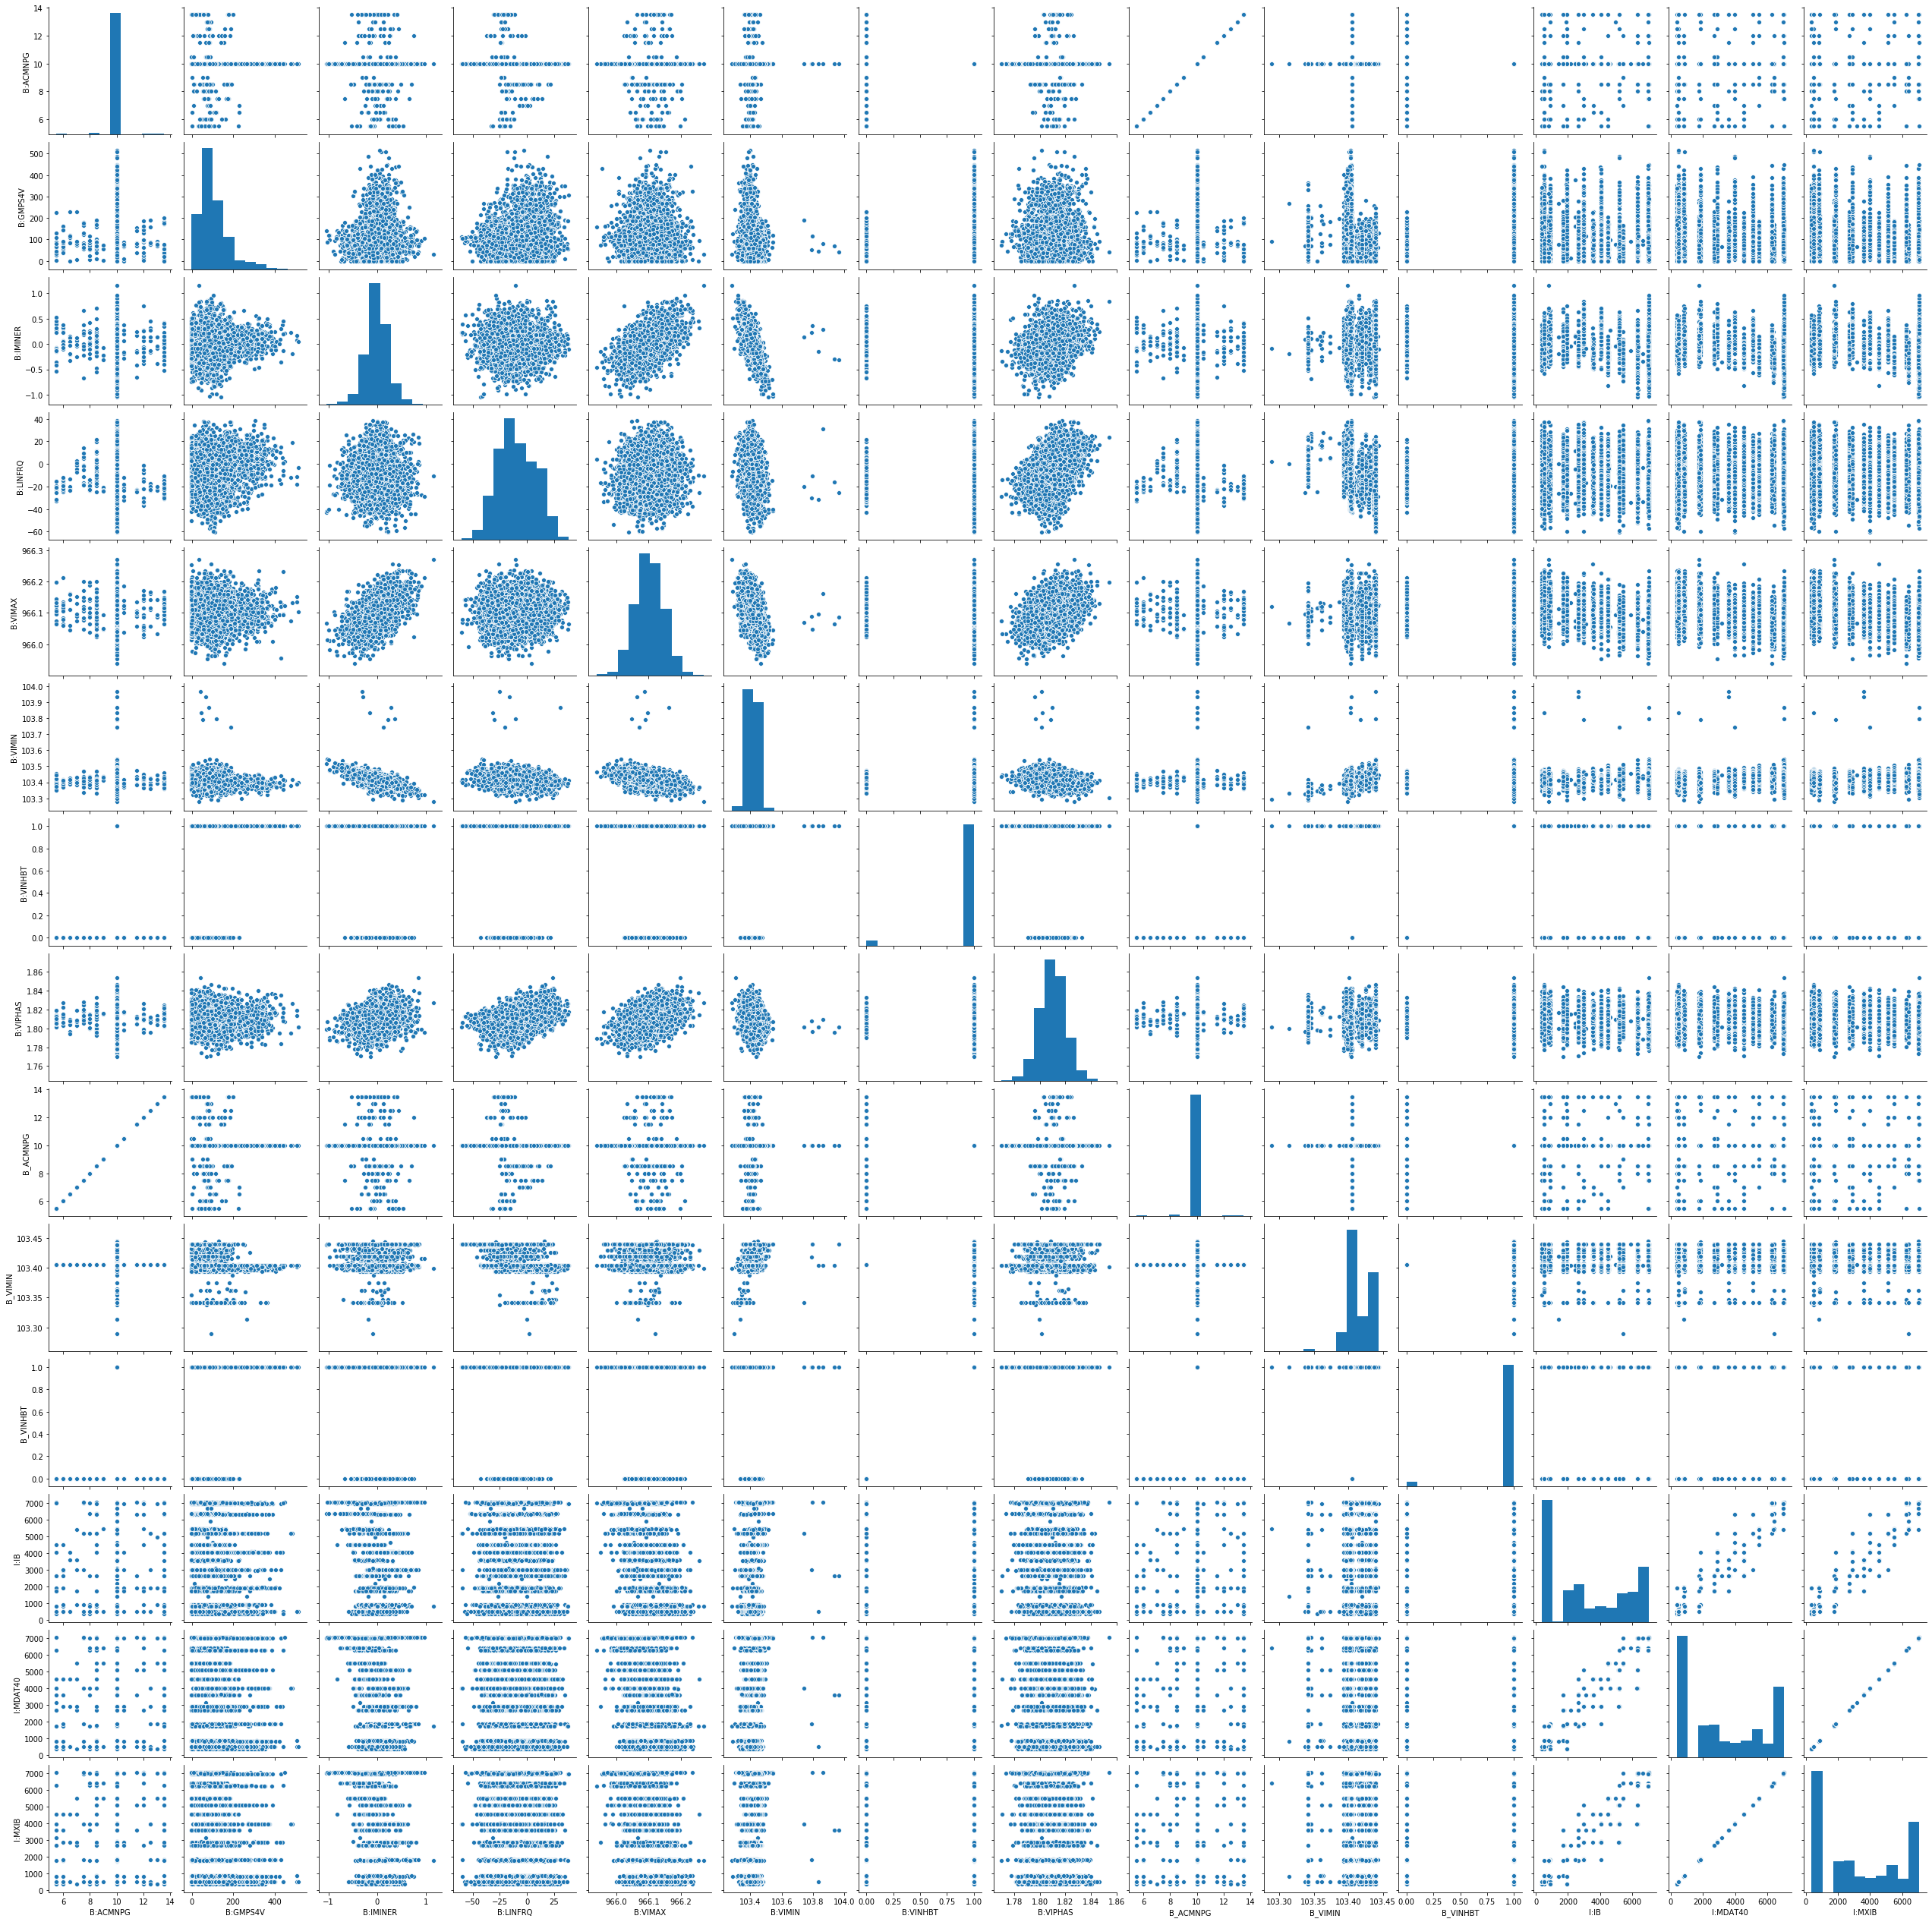

In [4]:
sns.pairplot(df.sample(5000),dropna=True);